
*OBS: All predictions of model is cached in "cache" folder. If you want to re-run the model, delete all the files inside "cache" folder.*

# Initial steps:

1. Download the dataset from [HERE](https://www.kaggle.com/datasets/gpiosenka/100-bird-species/data)

2. Extract the dataset to a folder named "dataset". Inside "dataset" folder, should have the folders "test", "train" and "valid"

3. Check if the folder is in the specified structure:
```
dataset\
  test\
    (birdName)\
      00x.jpg
  train\
    (birdName)\
      00x.jpg
  valid\
    (birdName)\
      00x.jpg
```

In [1]:
# Use python 3.8.10
import platform
if platform.python_version() != "3.8.10":
  raise Exception("Python version should be 3.8.10")

# Install Dependencies
!pip install \
keras==2.13.1 \
tensorflow==2.13.1 \
numpy==1.24.3 \
scikit-learn==1.3.2 \
torch==2.0.1 \
torchvision==0.15.2 \
tqdm==4.66.4 \
scipy==1.10.1 \
pandas==2.0.3 \
matplotlib==3.7.5 \
opencv-python==4.10.0.82 \
ultralytics==8.2.28 \
ipywidgets

You should consider upgrading via the '/home/caua/.pyenv/versions/3.8.10/bin/python3.8 -m pip install --upgrade pip' command.


In [24]:
from typing import Tuple

import os
import warnings
from sklearn.exceptions import UndefinedMetricWarning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

import numpy as np

import keras
import torch
from ultralytics import YOLO

from torchvision import transforms
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import ipywidgets as widgets
from IPython.display import display, clear_output
import io

In [25]:
train_dir = os.path.join(".", "dataset", "train")
test_dir = os.path.join(".", "dataset", "test")
valid_dir = os.path.join(".", "dataset", "valid")

classes = sorted(os.listdir(test_dir))
classes_index = {i[1]: i[0] for i in enumerate(classes)}

if set(os.listdir(test_dir)) != set(os.listdir(valid_dir)):
  print("Folders are different, so renaming to solve...")
  os.rename(os.path.join(valid_dir, "PARAKETT AUKLET"), os.path.join(valid_dir, "PARAKETT  AUKLET"))

# Loading models and calculating reports

In [26]:
model01 = keras.saving.load_model(os.path.join(".", "models", "modelo01.h5"))
precisionByClass01Path = os.path.join(".", "cache", "precisionByClass01.npy")
precisionByClass01 = np.load(precisionByClass01Path)

In [27]:
model02 = torch.jit.load(os.path.join(".", "models", "model02.zip"))
precisionByClass02Path = os.path.join("cache", "precisionByClass02.npy")
precisionByClass02 = np.load(precisionByClass02Path)

# Defining friendly interfaces to predict images

In [28]:
def predict01(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img, size = [224, 224])
  img = img/255.

  return model01.predict(tf.expand_dims(img, axis=0), verbose=None)

In [29]:
transform02 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(240),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

def predict02(image_path):
  image = Image.open(image_path)
  image = transform02(image).unsqueeze(0)
  
  with torch.no_grad():
      model02.eval()
      output = model02(image)
      probabilities = torch.nn.functional.softmax(output[0], dim=0)
  return np.array(probabilities)

In [30]:
def predict04(image_path, plotImage=False) -> Tuple[int, str]:
  pred_1 = predict01(image_path) * precisionByClass01
  pred_2 = predict02(image_path) * precisionByClass02
  pred_class = (pred_1 + pred_2).argmax()

  if plotImage == True:
    toPred = mpimg.imread(image_path)
    pred = mpimg.imread(os.path.join(".", train_dir, classes[pred_class], "001.jpg"))
    _, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(toPred)
    axs[0].axis('off')
    axs[0].set_title('Pássaro à prever', fontsize=12)

    axs[1].imshow(pred)
    axs[1].axis('off')
    axs[1].set_title('Provável espécie: ' + classes[pred_class], fontsize=12)

  return pred_class, classes[pred_class]

In [34]:
def pred_unprocessed_image(image_path, plot_image=False):
  image = cv2.imread(image_path)

  if plot_image == True:
    _, axs = plt.subplots(1, 1)
    axs.axis("off")
    axs.set_title("Imagem original")
    axs.imshow(plt.imread(image_path))
  
  model = YOLO(os.path.join('.', 'models', 'yolov8n.pt'))
  results = model.predict(image)
  class_names = model.names

  found = []
  for result in results[0].boxes:
      class_id = int(result.cls)

      if class_names[class_id] == 'bird':
          x1, y1, x2, y2 = map(int, result.xyxy[0])

          cropped_image = image[y1:y2, x1:x2]
          resized_image = cv2.resize(cropped_image, (224, 224))

          output_path = 'crop.jpg'
          cv2.imwrite(output_path, resized_image)

          pred = predict04(output_path, plotImage=plot_image)
          found.append(pred)

  if len(found) == 0:
    if plot_image == True:
      print('Nenhuma ave foi detectada na imagem.')
  return found

Arquivo recebido: 2especiesDiferentes.jpg

0: 448x640 2 birds, 328.4ms
Speed: 29.1ms preprocess, 328.4ms inference, 8.4ms postprocess per image at shape (1, 3, 448, 640)


FileUpload(value=({'name': '2especiesDiferentes.jpg', 'type': 'image/jpeg', 'size': 284882, 'content': <memory…

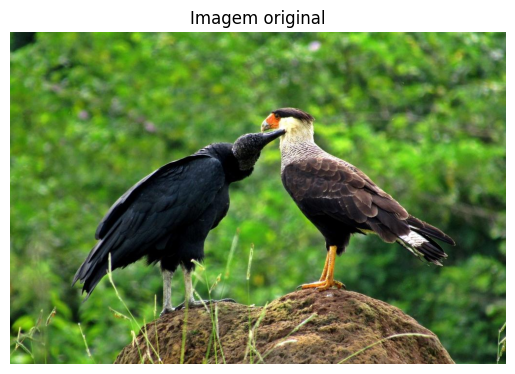

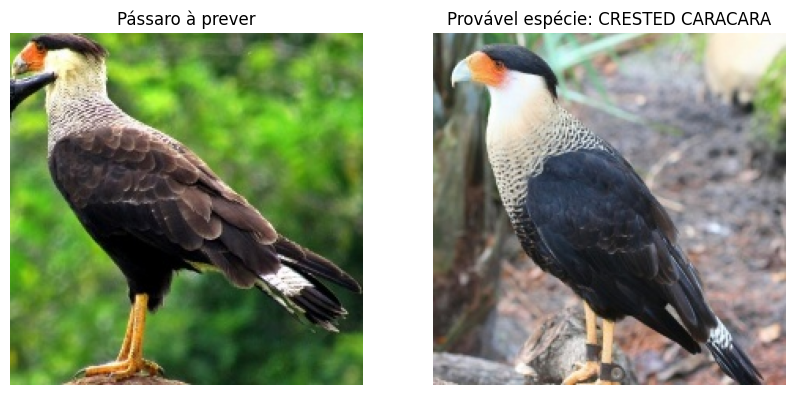

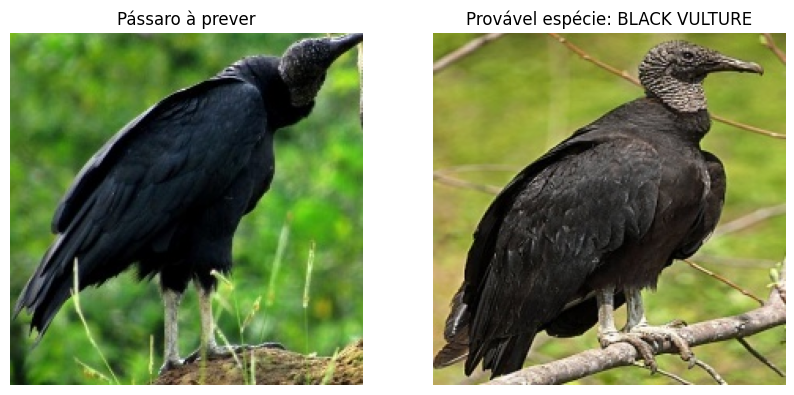

In [32]:
# Função para tratar o arquivo enviado
def on_upload_change(change):
    for upload in change['new']:
        clear_output(wait=True)
        print(f'Arquivo recebido: {upload["name"]}')

        image = Image.open(io.BytesIO(upload['content']))
        image.save('tmp.jpg')

        pred_unprocessed_image('tmp.jpg', plot_image=True)
        os.remove('tmp.jpg')
        display(upload_widget)

# Criar um widget de upload com estilo aumentado
upload_widget = widgets.FileUpload(
    accept='image/*',  # Aceitar apenas arquivos de imagem
    multiple=False,    # Não permitir múltiplos arquivos
    style={'description_width': 'initial'},
    layout=widgets.Layout(background_color= 'red', width='1000px', height='100px', display='flex', justify_content='center', align_items='center', margin='auto')  # Ajustar o layout do widget
)

# Associar a função de tratamento ao evento de mudança
upload_widget.observe(on_upload_change, names='value')

display(upload_widget)

In [19]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score

def healthCheckOfNewImages():
  pipe_dir = os.path.join(".", "pipes")
  to_train_dir = os.path.join(pipe_dir, "to-train")

  species = sorted(os.listdir(to_train_dir))
  species_num = {i[1]: i[0] for i in enumerate(species)}

  true = []
  pred = []

  for specie in species:
    imgs = os.listdir(os.path.join(to_train_dir, specie))
    for img in imgs:
      true.append(species_num[specie])
      predValue = predict04(os.path.join(to_train_dir, specie, img))[1]
      pred.append(species_num[predValue])
  
  report = classification_report(true, pred, target_names=species)
  accuracy = accuracy_score(true, pred)
  precision = precision_score(true, pred, average='weighted')
  f1 = f1_score(true, pred, average='weighted')

  return report, accuracy, precision, f1

In [20]:
report, accurracy, precision, f1 = healthCheckOfNewImages()

In [23]:
print(report)

                           precision    recall  f1-score   support

            BLACK VULTURE       1.00      1.00      1.00         1
BLONDE CRESTED WOODPECKER       1.00      1.00      1.00         1
              BLUE DACNIS       1.00      1.00      1.00         4
       CAATINGA CACHOLOTE       1.00      1.00      1.00         2
         CRESTED CARACARA       1.00      1.00      1.00         1
           GREAT KISKADEE       1.00      1.00      1.00         1
                  TOUCHAN       1.00      1.00      1.00         1

                 accuracy                           1.00        11
                macro avg       1.00      1.00      1.00        11
             weighted avg       1.00      1.00      1.00        11



(1.0, 1.0, 1.0)